# Solve frozen lake with Deep Q-Network

> By Jonas Busk ([jbusk@dtu.dk](mailto:jbusk@dtu.dk))

A big breakthrough in deep reinforcement learning happened in 2013 when DeepMind proposed a method called [Deep Q-network (DQN)](https://arxiv.org/abs/1312.5602) for training a neural network to play classic Atari games.
The method was described further in [Nature](https://www.nature.com/articles/nature14236) in 2015.
DQN is in many ways similar to the Q-network approach we saw in the previous notebook, but is extended with a few clever ideas to make it train better and more efficient. 

Two important additions were the use of an *experience replay memory* and a *target network*.
The experience replay memory is used to store previous state-actions transitions that can then be sampled in mini-batches and used for training.
This speeds up the training process by being more sample efficient and helps to break correlation between the sequentially observed experiences.
Sampling experiences in this way turns the method from an on-policy into an off-policy method. 
The target network uses a separate neural network to estimate the target values used in the update step.
As we saw in the previous notebook, the Q-network was also used to estimate the target values, which can make learning unstable as the network, and thus the targets, are updated frequently.
The target network is often just a previous version of the Q-network that is update less often to make the estimates more stable. 

Solve the [FrozenLake](https://gym.openai.com/envs/FrozenLake-v0/) environment using the Deep Q-Network (DQN) method with epsilon-greedy action selection, experience replay and a target network.

Just like the Q-Network, this approach employs a Q-function which can be updated using bootstrapping:

$$
Q(s,a;\theta) \leftarrow Q(s,a;\theta) + \alpha \delta \ ,
$$

where $\delta = r + \gamma \max_{a'} Q(s',a';\theta') - Q(s,a;\theta)$ is the TD error.

Since we use a neural network to represent $Q$, we cannot do this assignment directly, but instead perform a gradient update using sum of squares loss: 

$$
L(\theta) = \sum \delta^2 \ ,
$$

with a batch of transitions $(s,a,r,s')$ sampled from an experience replay memory. 

Notice how the DQN implementation uses a different set of parameters, $\theta'$, to compute the target value. This is the target network parameters which are a delayed copy of $\theta$.
The implementation below uses "soft" target updates rather than copying the weights periodically:

$$
\theta' \leftarrow \tau \, \theta + (1-\tau) \, \theta' \ ,
$$

with $\tau \ll 1$.

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import random
from collections import deque
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import gym

In [2]:
# initialize environment
env = gym.make('FrozenLake-v0')

In [3]:
# show initial state
s = env.reset()
env.render()


SFFF
FHFH
FFFH
HFFG


Let's define an experience replay memory that can be used to store new transitions and sample mini-batches of previous transitions. 

In [10]:
class ReplayMemory(object):
    """Experience Replay Memory"""
    
    def __init__(self, capacity):
        #self.size = size
        self.memory = deque(maxlen=capacity)
    
    def add(self, *args):
        """Add experience to memory."""
        self.memory.append([*args])
    
    def sample(self, batch_size):
        """Sample batch of experiences from memory with replacement."""
        return random.sample(self.memory, batch_size)
    
    def count(self):
        return len(self.memory)

The Q-network is very similar to the one we have seen previously, but we add the possibility to update the parameters, so the same class can also be used as a target network.  

In [7]:
class DQN(nn.Module):
    """Deep Q-network with target network"""
    
    def __init__(self, n_inputs, n_outputs, learning_rate):
        super(DQN, self).__init__()
        # network
        self.out = nn.Sequential(nn.Linear(n_inputs, 64),
                                nn.ELU(),
                                nn.Linear(64, n_outputs))
        # training
        self.optimizer = optim.SGD(self.parameters(), lr=learning_rate)
    
    def forward(self, x):
        return self.out(x)
    
    def loss(self, q_outputs, q_targets):
        return torch.sum(torch.pow(q_targets - q_outputs, 2))
    
    def update_params(self, new_params, tau):
        params = self.state_dict()
        for k in params.keys():
            params[k] = (1-tau) * params[k] + tau * new_params[k]
        self.load_state_dict(params)

In [8]:
# one-hot encoder for the states
def one_hot(i, l):
    a = np.zeros((len(i), l))
    a[range(len(i)), i] = 1
    return a

Before training, we create a policy network and copy its weight parameters to a target network, so they are initially the same. 
We also set up a replay memory and prefill it with random transitions sampled from the environment. 

In [13]:
# train Deep Q-network

num_episodes = 1000
episode_limit = 100
batch_size = 64
learning_rate = 0.005
gamma = 0.99 # discount rate
tau = 0.01 # target network update rate
replay_memory_capacity = 10000
prefill_memory = True
val_freq = 100 # validation frequency

n_inputs = env.observation_space.n
n_outputs = env.action_space.n

# initialize DQN and replay memory
policy_dqn = DQN(n_inputs, n_outputs, learning_rate)
target_dqn = DQN(n_inputs, n_outputs, learning_rate)
target_dqn.load_state_dict(policy_dqn.state_dict())

replay_memory = ReplayMemory(replay_memory_capacity)

# prefill replay memory with random actions
if prefill_memory:
    print('prefill replay memory')
    s = env.reset()
    while replay_memory.count() < replay_memory_capacity:
        a = env.action_space.sample()
        s1, r, d, _ = env.step(a)
        replay_memory.add(s, a, r, s1, d)
        s = s1 if not d else env.reset()
        
# training loop
try:
    print('start training')
    epsilon = 1.0
    rewards, lengths, losses, epsilons = [], [], [], []
    for i in range(num_episodes):
        # init new episode
        s, ep_reward, ep_loss = env.reset(), 0, 0
        for j in range(episode_limit):
            # select action with epsilon-greedy strategy
            if np.random.rand() < epsilon:
                a = env.action_space.sample()
            else:
                with torch.no_grad():
                    a = policy_dqn(torch.from_numpy(one_hot([s], n_inputs)).float()).argmax().item()
            # perform action
            s1, r, d, _ = env.step(a)
            # store experience in replay memory
            replay_memory.add(s, a, r, s1, d)
            # batch update
            if replay_memory.count() >= batch_size:
                # sample batch from replay memory
                batch = np.array(replay_memory.sample(batch_size), dtype=int)
                ss, aa, rr, ss1, dd = batch[:,0], batch[:,1], batch[:,2], batch[:,3], batch[:,4]
                # do forward pass of batch
                policy_dqn.optimizer.zero_grad()
                Q = policy_dqn(torch.from_numpy(one_hot(ss, n_inputs)).float())
                # use target network to compute target Q-values
                with torch.no_grad():
                    # TODO: use target net
                    Q1 = target_dqn(torch.from_numpy(one_hot(ss1, n_inputs)).float())
                # compute target for each sampled experience
                q_targets = Q.clone()
                for k in range(batch_size):
                    q_targets[k, aa[k]] = rr[k] + gamma * Q1[k].max().item() * (not dd[k])
                # update network weights
                loss = policy_dqn.loss(Q, q_targets)
                loss.backward()
                policy_dqn.optimizer.step()
                # update target network parameters from policy network parameters
                target_dqn.update_params(policy_dqn.state_dict(), tau)
            else:
                loss = 0
            # bookkeeping
            s = s1
            ep_reward += r
            ep_loss += loss.item()
            if d: break
        # bookkeeping
        epsilon *= num_episodes/(i/(num_episodes/20)+num_episodes) # decrease epsilon
        epsilons.append(epsilon); rewards.append(ep_reward); lengths.append(j+1); losses.append(ep_loss)
        if (i+1) % val_freq == 0: print('%5d mean training reward: %5.2f' % (i+1, np.mean(rewards[-val_freq:])))
    print('done')
except KeyboardInterrupt:
    print('interrupt')

prefill replay memory
start training
  100 mean training reward:  0.01
  200 mean training reward:  0.02
  300 mean training reward:  0.07
  400 mean training reward:  0.10
  500 mean training reward:  0.27
  600 mean training reward:  0.47
  700 mean training reward:  0.62
  800 mean training reward:  0.60
  900 mean training reward:  0.68
 1000 mean training reward:  0.69
done


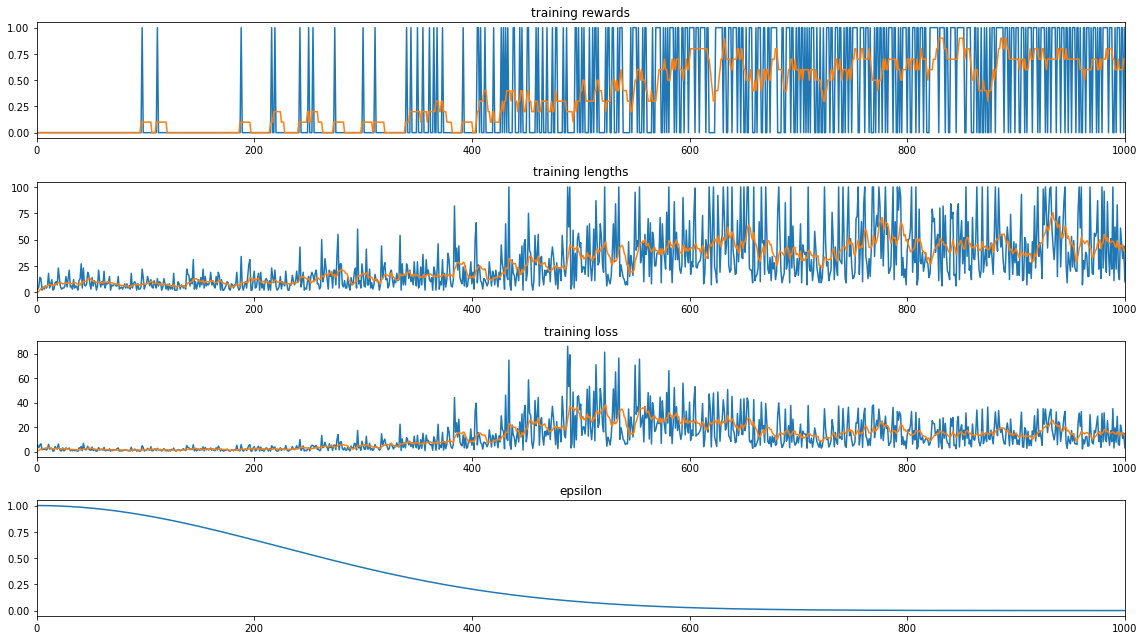

In [14]:
# plot results
def moving_average(a, n=10) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret / n

plt.figure(figsize=(16, 9))
plt.subplot(411)
plt.title('training rewards')
plt.plot(range(1, num_episodes+1), rewards)
plt.plot(moving_average(rewards))
plt.xlim([0, num_episodes])
plt.subplot(412)
plt.title('training lengths')
plt.plot(range(1, num_episodes+1), lengths)
plt.plot(range(1, num_episodes+1), moving_average(lengths))
plt.xlim([0, num_episodes])
plt.subplot(413)
plt.title('training loss')
plt.plot(range(1, num_episodes+1), losses)
plt.plot(range(1, num_episodes+1), moving_average(losses))
plt.xlim([0, num_episodes])
plt.subplot(414)
plt.title('epsilon')
plt.plot(range(1, num_episodes+1), epsilons)
plt.xlim([0, num_episodes])
plt.tight_layout(); plt.show()

In [16]:
s = env.reset()
env.render()
for i in range(100):
    a = policy_dqn(torch.from_numpy(one_hot([s], n_inputs)).float()).argmax().item()
    s, r, done, _ = env.step(a)
    env.render()
    if done:
        print(i)
        break


SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Up)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
11


Even though here we have applied DQN to a rather simple problem, hopefully you can see how this can be scaled up to solve more challenging tasks.
For example by adding convolutional layers to the network and learning to play Atari games!

## Popular extensions of DQN

After the initial success of DQN, the method as been extended in a number of ways. Some popular improvements are:

* [Deep Reinforcement Learning with Double Q-learning](https://arxiv.org/abs/1509.06461)
* [Prioritized Experience Replay](https://arxiv.org/abs/1511.05952)
* [Dueling Network Architectures for Deep Reinforcement Learning](https://arxiv.org/abs/1511.06581)

## Exercises

Make sure you read and understand the code, and feel free to experiment with the:

* number of episodes
* discount factor
* learning rate
* network layers


### Exercise 1

*Did you see any improvements over the regular Q-network from the previous notebook? Why/why not?*

**Answer:**

*There are huge improvements. DQN only takes 11 actions to arrive at the destination while the regular Q-network takes 39 actions.*

### Exercise 2 

*Solve another (harder) environment from OpenAI Gym with DQN. Describe the choices you made and what you learned.*

*Hint: If you for example want to master a Atari game, add convolutional layers to the network. *

**Answer:**

*I'm not able to make Atari environment.*

### Exercise 3

*Improve the DQN algorithm with one or more of the popular extensions described above. Describe the choices you made and what you learned.*

**Answer:**

*raise NotImplementedError*
